In [1]:
%%capture
%cd ..

In [2]:
from src.model.esn import ESN
from src.model.lstm import LSTM
from src.trainer.ridge_regression_trainer import RidgeRegressionTrainer
from src.trainer.bptt_trainer import BPTTTrainer
from src.dataset import create_sifim_datasets
from src.trainer.model_selection import retraining
import torch
import matplotlib.pyplot as plt
import time
from codecarbon import EmissionsTracker

In [3]:
batch_size = 16
shuffle = True

tr_dataset, vl_dataset, ts_dataset = create_sifim_datasets(vl_perc=0.2, ts_perc=0.2, noise=0.005)

In [4]:
def format_result(result, start_time, tracker):
    emissions = tracker.stop()
    tracker.start()
    return dict(mse=result[0], time=time.time() - start_time, emissions=emissions, **result[3])

In [5]:
lstm_results = []
tracker = EmissionsTracker(log_level="critical", save_to_file=False)
tracker.start()
start_time = time.time()

def store_lstm_accuracy(trainer):
    lstm_results.append(format_result(trainer.test(), start_time, tracker))

retraining(
    model_constructor=LSTM,
    trainer_constructor=lambda *args, **kwargs: BPTTTrainer(*args, callback=store_lstm_accuracy, **kwargs),
    tr_dataset=tr_dataset,
    ts_dataset=ts_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    hyperparams_path=f'hyperparams/LSTM_hyperparams.json',
    model_path=None,
    history_path=None,
)

/Users/geremiapompei/Desktop/Progetti/energiai/venv/lib/python3.10/site-packages/codecarbon/output.py:168: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(data.values)])])


2023-12-18 23:49:51,385 - root - INFO - LSTM results => training loss: 4.311533096894498e-06, test loss: 1.7466640614640906e-05, tr_time: 174.96612691879272, tr_emissions: 0.00018219493875972035, ts_time: 1.3867230415344238, ts_emissions: 1.4442577918159961e-06, scores: {'accuracy': 0.8212783014807162, 'precision': 0.9384791854187047, 'recall': 0.7132199839302111, 'f1_score': 0.8104643266751669}


LSTM(
  (lstm): LSTM(88, 200, batch_first=True)
  (ff): Linear(in_features=200, out_features=88, bias=True)
)

In [5]:
tracker = EmissionsTracker(log_level="critical", save_to_file=False)
tracker.start()
start_time = time.time()
esn_results = format_result(RidgeRegressionTrainer(
    torch.load('models/ESN.torch'),
    torch.utils.data.DataLoader(tr_dataset, batch_size=batch_size, shuffle=shuffle),
    torch.utils.data.DataLoader(ts_dataset, batch_size=batch_size, shuffle=shuffle),
).test(), start_time, tracker)

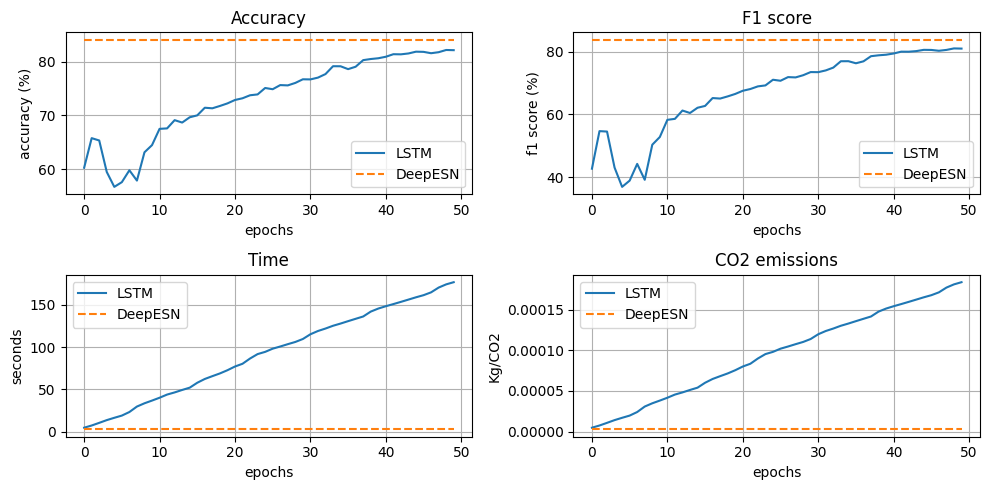

In [7]:
_, axs = plt.subplots(2, 2, figsize=(10, 5))
for i, (key, label, ylabel, m) in enumerate([
    ('accuracy', 'Accuracy', 'accuracy (%)', 100),
    ('f1_score', 'F1 score', 'f1 score (%)', 100),
    ('time', 'Time', 'seconds', 1),
    ('emissions', 'CO2 emissions', 'Kg/CO2', 1)
]):
    ax = axs[i // 2][i % 2]
    ax.set_title(label)
    ax.plot([r[key] * m for r in lstm_results], label='LSTM')
    ax.plot([esn_results[key] * m for _ in lstm_results], linestyle='--', label='DeepESN')
    ax.set_xlabel('epochs')
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend()
plt.tight_layout()
plt.savefig(f'plots/development_metrics.png')
plt.show()

In [8]:
def plot(key):
    plt.figure(figsize=(12, 7))
    plt.title(key)
    plt.plot([r[key] for r in lstm_results], label='LSTM')
    plt.plot([esn_results[key] for _ in lstm_results], linestyle='--', label='ESN')
    plt.xlabel('epochs')
    plt.ylabel(key)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'plots/development_{key}')
    plt.show()

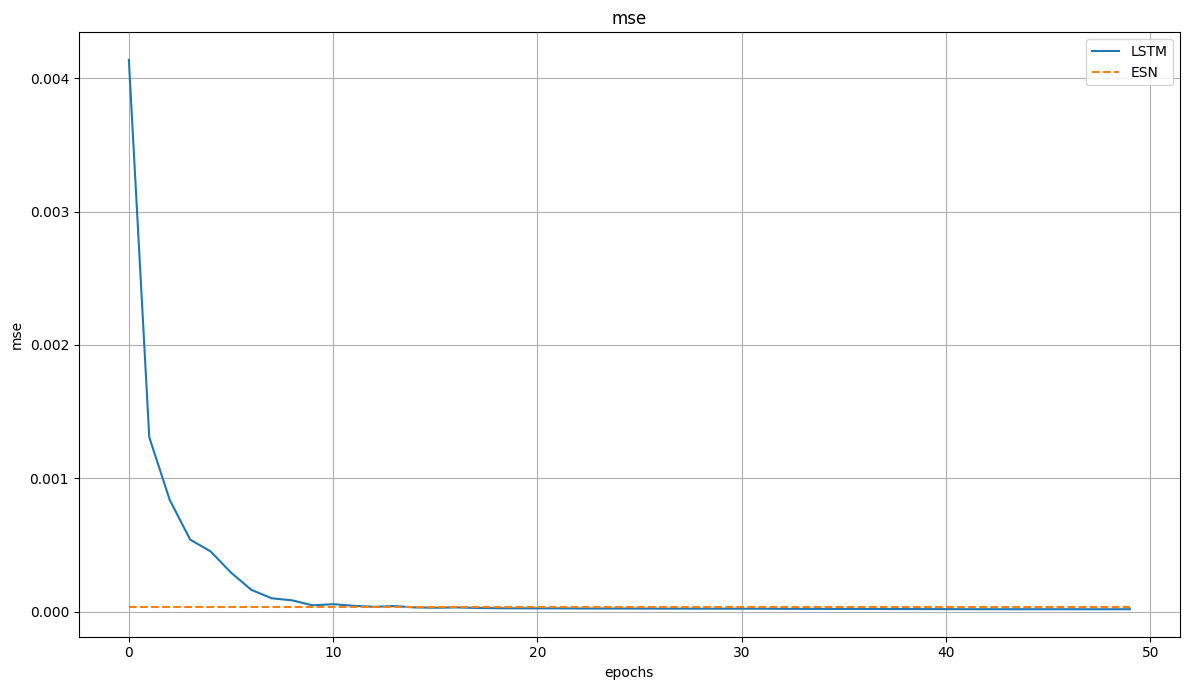

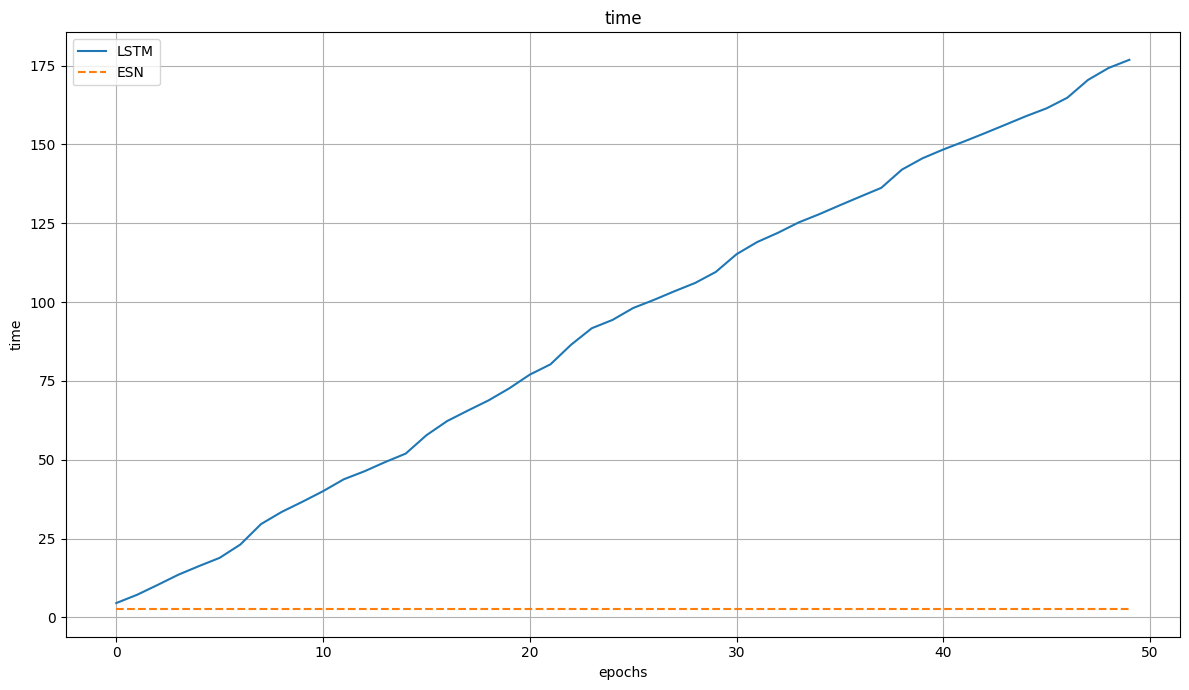

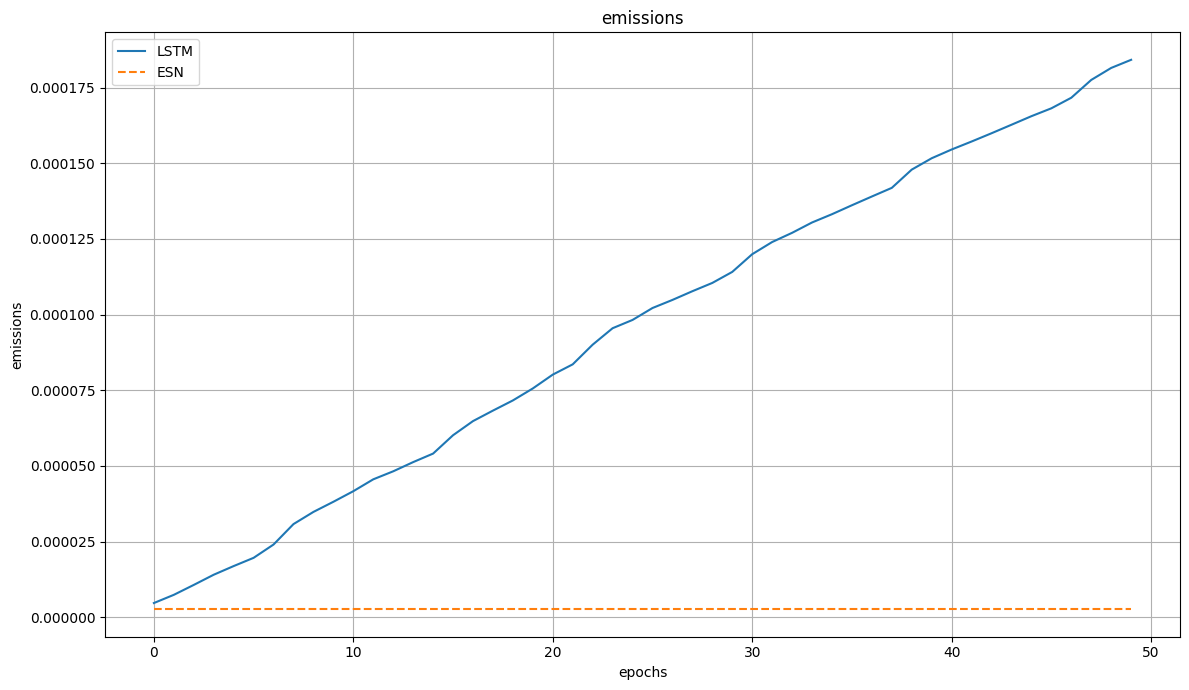

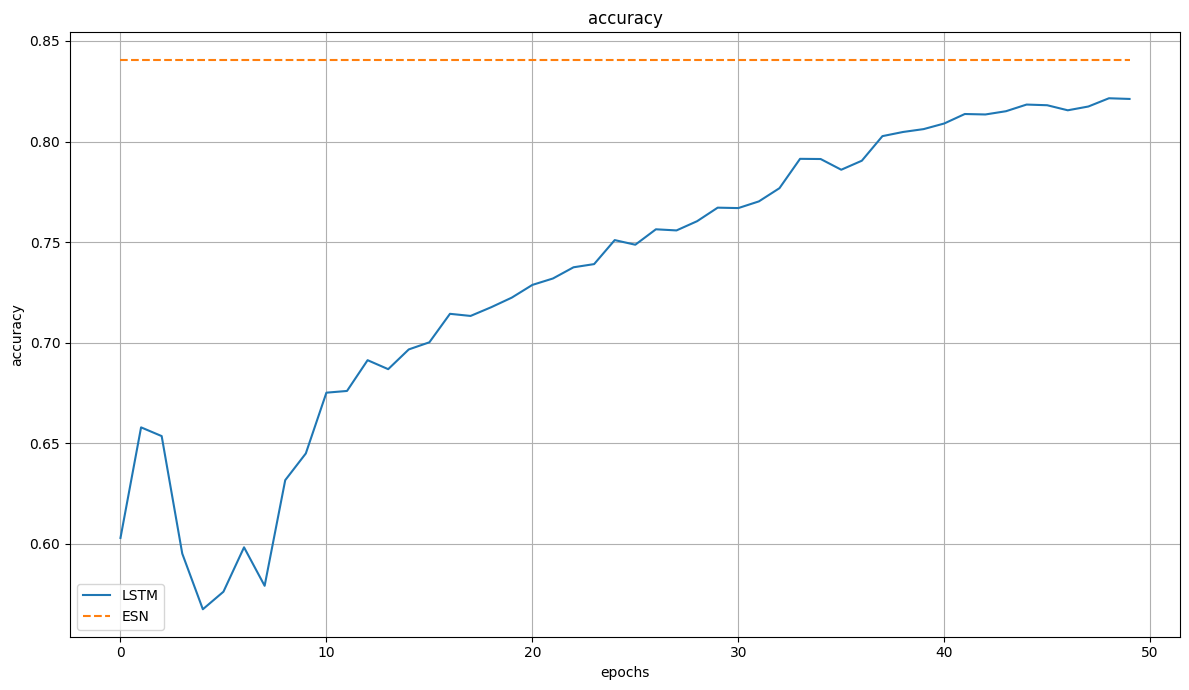

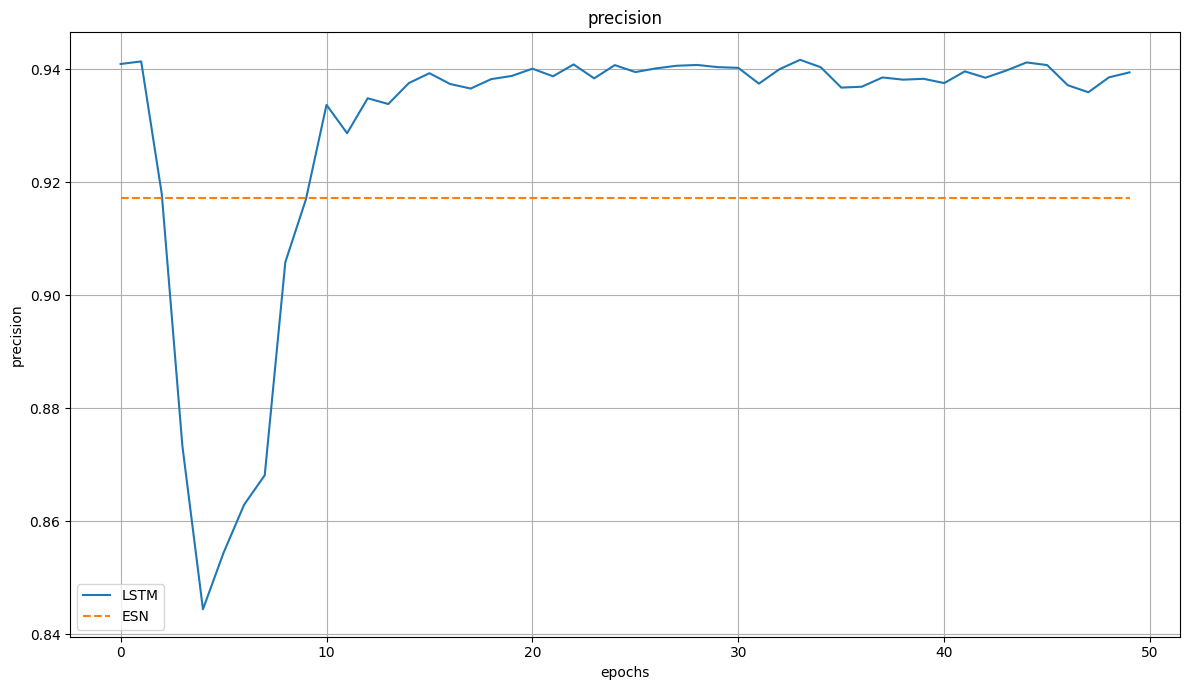

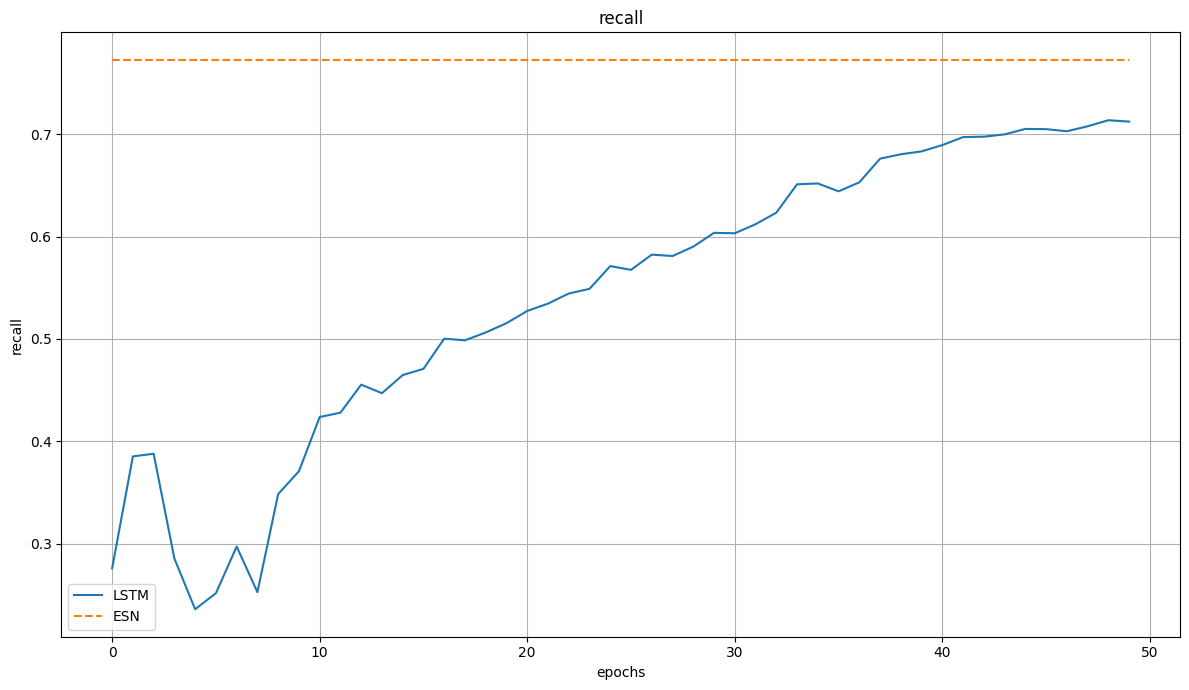

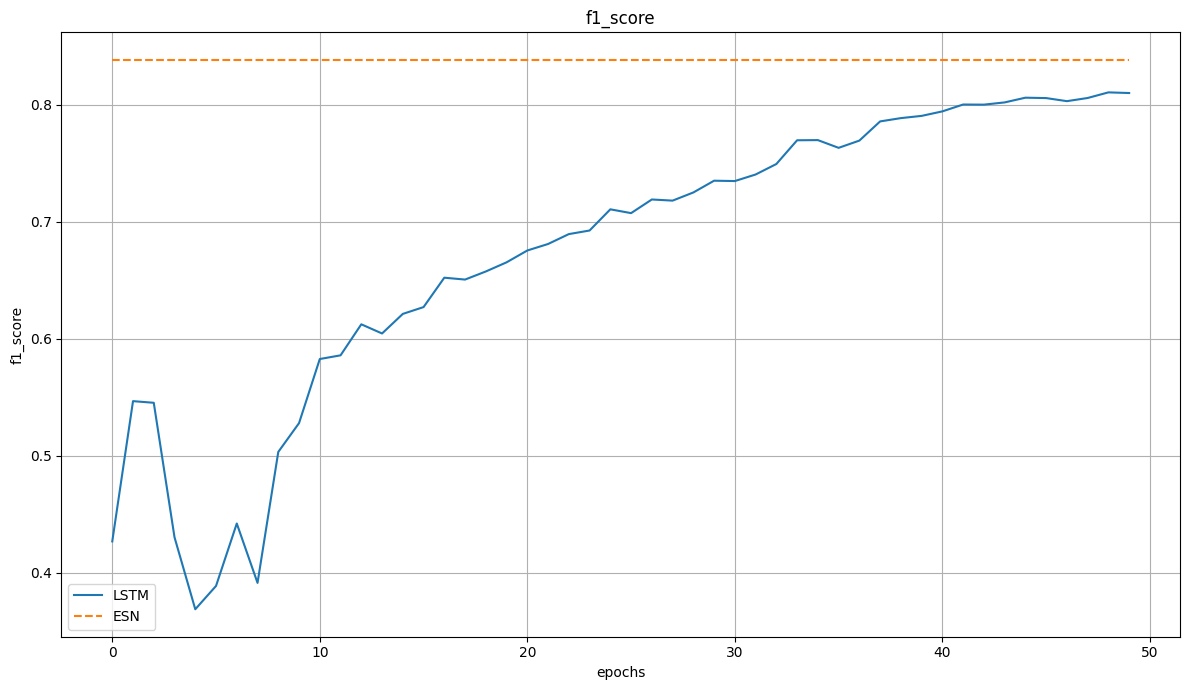

In [9]:
for k in esn_results.keys():
    plot(k)